In [1]:
!nvidia-smi

Tue Mar 18 06:29:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
# YOLOv8 kütüphanesini yükler (belirli versiyon)
!pip install ultralytics==8.0.196

# Jupyter/Colab ekranını temizler
from IPython import display
display.clear_output()

# Ultralytics kütüphanesini içe aktarır ve sistem uyumluluğunu kontrol eder
import ultralytics
ultralytics.checks()


Ultralytics YOLOv8.0.196 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.0/112.6 GB disk)


In [4]:
from ultralytics import YOLO

from IPython.display import display, Image


In [ ]:
# Yeni bir 'datasets' klasörü oluşturulur ve içine geçilir
!mkdir {HOME}/datasets
%cd {HOME}/datasets

# Roboflow kütüphanesi sessiz ve normal şekilde yüklenir
!pip install roboflow --quiet
!pip install roboflow

# Roboflow üzerinden veri kümesi indirilir
from roboflow import Roboflow
rf = Roboflow(api_key="8bierltjHoonW1DttJO6")  # API anahtarı ile giriş yapılır
project = rf.workspace("amar-lounis-xjgqd").project("33-36-plaka.v1i.yolov8")  # İlgili proje çağrılır
version = project.version(1)  # Versiyon belirlenir
dataset = version.download("yolov8")  # YOLOv8 formatında veri kümesi indirilir


mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...


In [ ]:
import shutil, os, glob  # Dosya ve klasör işlemleri
import cv2  # Görüntü işleme
import albumentations as A  # Augmentasyon kütüphanesi

# Görseller üzerinde renk ve bulanıklık etkileriyle genel augmentasyon uygular
def general_augmentation(image):
    transform_color = A.Compose([
        A.RandomBrightnessContrast(p=0.6),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
        A.MotionBlur(blur_limit=3, p=0.4)
    ])
    return transform_color(image=image)['image']

# Veri yolları
dataset_path = "/content/datasets/33-36-plaka.v1i.yolov8-1/train"
general_augmented_path = "/content/datasets/general_augmented"

# Mevcut augment klasörü varsa sil, sonra yeniden oluştur
if os.path.exists(general_augmented_path):
    shutil.rmtree(general_augmented_path)
os.makedirs(os.path.join(general_augmented_path, "images"), exist_ok=True)
os.makedirs(os.path.join(general_augmented_path, "labels"), exist_ok=True)

# Tüm eğitim görselleri alınır
image_files = glob.glob(os.path.join(dataset_path, "images", "*.jpg"))

# Her görsel için augmentasyon uygulanır ve kopyalanır
for img_path in image_files:
    label_path = img_path.replace("/images/", "/labels/").replace(".jpg", ".txt")
    if not os.path.exists(label_path):
        continue

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transformed_general = general_augmentation(image)

    # Yeni augment edilmiş görsel ve etiketi kaydet
    general_img_path = os.path.join(general_augmented_path, "images", "general_" + os.path.basename(img_path))
    cv2.imwrite(general_img_path, cv2.cvtColor(transformed_general, cv2.COLOR_RGB2BGR))
    shutil.copy(label_path, os.path.join(general_augmented_path, "labels", "general_" + os.path.basename(label_path)))

print("✅ Genel augmentasyon tamamlandı! Augmented dosyalar general_augmented klasörüne kaydedildi!")


Argument(s) 'var_limit' are not valid for transform GaussNoise


✅ Genel augmentasyon tamamlandı! Augmented dosyalar general_augmented klasörüne kaydedildi!


In [ ]:
# Gerekli kütüphaneler
import os, glob
import pandas as pd  # Tablo işlemleri
import matplotlib.pyplot as plt
import cv2, random

# Augmented klasör yolu
general_augmented_path = "/content/datasets/general_augmented"

# Augmented veri setindeki görsel ve etiket sayısı hesaplanır
num_augmented_images = len(glob.glob(os.path.join(general_augmented_path, "images", "*.jpg")))
num_augmented_labels = len(glob.glob(os.path.join(general_augmented_path, "labels", "*.txt")))

# Sayısal sonuçlar sözlük olarak tutulur
result = {
    "Augmented Görüntü Sayısı": num_augmented_images,
    "Augmented Label Sayısı": num_augmented_labels
}

# Veriler pandas ile tablo şeklinde gösterilir
df = pd.DataFrame(list(result.items()), columns=["Özellik", "Sayı"])
df


,Özellik,Sayı
0,Augmented Görüntü Sayısı,1906
1,Augmented Label Sayısı,1906


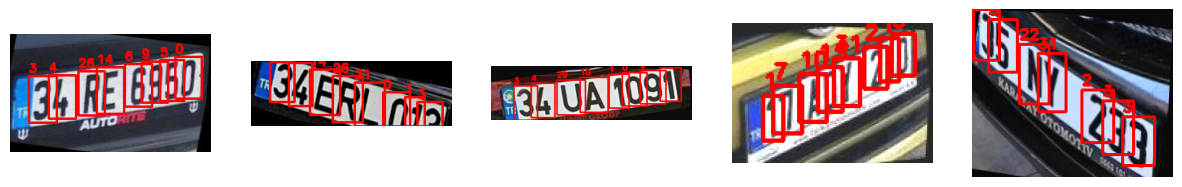

In [ ]:
# Augment edilmiş verilerden rastgele 5 görsel seçilir
random_images = random.sample(image_files, min(5, len(image_files)))

# Bounding box çizme fonksiyonu tanımlanır
def draw_bounding_boxes(image_path, label_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Etiket dosyasından koordinatlar okunur ve kutular çizilir
    with open(label_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            values = line.strip().split()
            class_id = int(values[0])
            x_center, y_center, box_w, box_h = map(float, values[1:])

            # YOLO formatı → piksel koordinatlarına dönüşüm
            x1 = int((x_center - box_w / 2) * w)
            y1 = int((y_center - box_h / 2) * h)
            x2 = int((x_center + box_w / 2) * w)
            y2 = int((y_center + box_h / 2) * h)

            # Kırmızı kutu ve class ID çizimi
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img, str(class_id), (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return img

# Seçilen görseller kutularla birlikte çizdirilir
fig, axes = plt.subplots(1, len(random_images), figsize=(15, 5))

if len(random_images) == 1:
    axes = [axes]

for ax, image_path in zip(axes, random_images):
    label_path = image_path.replace("/images/", "/labels/").replace(".jpg", ".txt")
    if os.path.exists(label_path):
        img_with_boxes = draw_bounding_boxes(image_path, label_path)
        ax.imshow(img_with_boxes)
    else:
        ax.imshow(cv2.imread(image_path)[..., ::-1])
    ax.axis("off")

plt.show()


In [ ]:
import shutil, os, glob, cv2
import albumentations as A
import numpy as np, random
from PIL import Image, ImageEnhance, ImageFilter

# OCR'nin genelde karıştırdığı karakterler (0-O, 1-I, 5-S vs.)
hard_characters = {'0', 'O', '1', 'I', 'B', '8', '5', 'S', 'D', 'C', 'G', '7', 'T', '2', 'Z'}
hard_characters_mapping = {
    '0': '0', 'O': '24', '1': '1', 'I': '18', 'B': '11', '8': '8', '5': '5', 'S': '27',
    'D': '13', 'C': '12', 'G': '16', '7': '7', 'T': '28', '2': '2', 'Z': '32'
}

# Zor karakterler için özel augmentasyon (kontrast, bulanıklık, eğme)
def augment_hard_characters(img):
    img = ImageEnhance.Contrast(img).enhance(random.uniform(1.1, 1.8))
    img = img.filter(ImageFilter.GaussianBlur(random.uniform(0.3, 1.0)))
    img = img.transform(img.size, Image.AFFINE, (1, random.uniform(-0.2, 0.2), 0, 0, 1, 0))
    return img

# Veri yolları
dataset_path = "/content/datasets/33-36-plaka.v1i.yolov8-1/train"
hard_character_only_path = "/content/datasets/hard_character_only"

# Eğer klasör varsa sil, yeniden oluştur
if os.path.exists(hard_character_only_path):
    shutil.rmtree(hard_character_only_path)
os.makedirs(os.path.join(hard_character_only_path, "images"), exist_ok=True)
os.makedirs(os.path.join(hard_character_only_path, "labels"), exist_ok=True)

# Eğitim setindeki tüm görseller alınır
image_files = glob.glob(os.path.join(dataset_path, "images", "*.jpg"))

# Etiket dosyalarında zor karakter geçenler ayrı klasöre kopyalanır
for img_path in image_files:
    label_path = img_path.replace("/images/", "/labels/").replace(".jpg", ".txt")
    if not os.path.exists(label_path):
        continue

    with open(label_path, "r") as f:
        lines = f.readlines()
        contains_hard_character = any(values[0] in hard_characters_mapping.values() for line in lines for values in [line.strip().split()])

    if contains_hard_character:
        shutil.copy(img_path, os.path.join(hard_character_only_path, "images", os.path.basename(img_path)))
        shutil.copy(label_path, os.path.join(hard_character_only_path, "labels", os.path.basename(label_path)))

print("✅ Sadece OCR'nin zorlandığı karakterleri içeren görüntüler hard_character_only klasörüne ayrıldı!")


✅ Sadece OCR'nin zorlandığı karakterleri içeren görüntüler hard_character_only klasörüne ayrıldı!


In [ ]:
# Özel karakter içeren görsel ve etiket sayısını hesapla
hard_character_images = len(glob.glob(os.path.join(hard_character_only_path, "images", "*.jpg")))
hard_character_labels = len(glob.glob(os.path.join(hard_character_only_path, "labels", "*.txt")))

# Sonuçlar sözlük olarak saklanır
result = {
    "Özel Karakter İçeren Görüntü Sayısı": hard_character_images,
    "Özel Karakter İçeren Label Sayısı": hard_character_labels
}

# Pandas ile tablo halinde gösterilir
df = pd.DataFrame(list(result.items()), columns=["Özellik", "Sayı"])
df


,Özellik,Sayı
0,Özel Karakter İçeren Görüntü Sayısı,1875
1,Özel Karakter İçeren Label Sayısı,1875


In [ ]:
# Eğitim veri yolu yeniden tanımlanır
hard_character_only_path = "/content/datasets/33-36-plaka.v1i.yolov8-1/train"

# Eğitim klasöründeki tüm görsel ve etiket dosyalarının sayısı hesaplanır
hard_character_images = len(glob.glob(os.path.join(hard_character_only_path, "images", "*.jpg")))
hard_character_labels = len(glob.glob(os.path.join(hard_character_only_path, "labels", "*.txt")))

# Sonuçlar sözlükte tutulur ve tabloya dönüştürülür
result = {
    "Train Görüntü Sayısı": hard_character_images,
    "Train Label Sayısı": hard_character_labels
}

df = pd.DataFrame(list(result.items()), columns=["Özellik", "Sayı"])
df


,Özellik,Sayı
0,Train Görüntü Sayısı,1906
1,Train Label Sayısı,1906


In [13]:
print(glob.glob("/content/datasets/hard_character_only/images/*.jpg"))
print(glob.glob("/content/datasets/hard_character_only/labels/*.txt"))


['/content/datasets/hard_character_only/images/895_jpg.rf.7b836d667a2e846af8627c7e9e07bb0b.jpg', '/content/datasets/hard_character_only/images/320_jpg.rf.45195fdd9ad22fb581875c71422b62b8.jpg', '/content/datasets/hard_character_only/images/133_jpg.rf.b543455dda2bf775b0957708d28c30b2.jpg', '/content/datasets/hard_character_only/images/105_jpg.rf.1e7655bd489af99cb0bc2480574a58d8.jpg', '/content/datasets/hard_character_only/images/19_jpg.rf.dafb8c9fdc4bfaa49e2cfb58f74a1c0c.jpg', '/content/datasets/hard_character_only/images/657_jpg.rf.91d82f28ca639bbb023a0dec84fd14ef.jpg', '/content/datasets/hard_character_only/images/211_jpg.rf.f1b4d11f400eb1d6c69588a1badfe226.jpg', '/content/datasets/hard_character_only/images/622_jpg.rf.c23863e50a74899e413f4bf3075fc7f5.jpg', '/content/datasets/hard_character_only/images/701_jpg.rf.42ece117e86f5590ba232527cc0403f7.jpg', '/content/datasets/hard_character_only/images/1025_jpg.rf.2c009672f0311965206379fed954914a.jpg', '/content/datasets/hard_character_only/

In [ ]:
import shutil, os, glob, cv2
import albumentations as A
import numpy as np, random
from PIL import Image, ImageEnhance, ImageFilter

# OCR'nin karıştırdığı karakterler ve karşılık gelen sınıf ID'leri
hard_characters = {'0', 'O', '1', 'I', 'B', '8', '5', 'S', 'D', 'C', 'G', '7', 'T', '2', 'Z'}
hard_characters_mapping = {
    '0': '0', 'O': '24', '1': '1', 'I': '18', 'B': '11', '8': '8', '5': '5', 'S': '27',
    'D': '13', 'C': '12', 'G': '16', '7': '7', 'T': '28', '2': '2', 'Z': '32'
}

# Bu karakterlere özel bulanıklık, kontrast ve eğme içeren augmentasyon
def augment_hard_characters(img):
    img = ImageEnhance.Contrast(img).enhance(random.uniform(1.1, 1.8))
    img = img.filter(ImageFilter.GaussianBlur(random.uniform(0.3, 1.0)))
    img = img.transform(img.size, Image.AFFINE, (1, random.uniform(-0.2, 0.2), 0, 0, 1, 0))
    return img

# Veri yolları
dataset_path = "/content/datasets/33-36-plaka.v1i.yolov8-1/train"
hard_character_only_path = "/content/datasets/hard_character_only"
hard_augmented_path = "/content/datasets/hard_augmented"

# Eski klasör varsa sil, yeniden oluştur
if os.path.exists(hard_augmented_path):
    shutil.rmtree(hard_augmented_path)
os.makedirs(os.path.join(hard_augmented_path, "images"), exist_ok=True)
os.makedirs(os.path.join(hard_augmented_path, "labels"), exist_ok=True)

# OCR açısından zor karakterler içeren görseller alınır
image_files = glob.glob(os.path.join(hard_character_only_path, "images", "*.jpg"))

# Her görsele augmentasyon uygulanır ve yeni isimle kaydedilir
for img_path in image_files:
    label_path = img_path.replace("/images/", "/labels/").replace(".jpg", ".txt")
    if not os.path.exists(label_path):
        continue

    image = cv2.imread(img_path)
    img_pil = Image.fromarray(image)
    transformed_hard = augment_hard_characters(img_pil)

    # Yeni augment edilmiş görsel ve etiketi kaydet
    hard_img_path = os.path.join(hard_augmented_path, "images", "hard_" + os.path.basename(img_path))
    transformed_hard.save(hard_img_path)
    shutil.copy(label_path, os.path.join(hard_augmented_path, "labels", "hard_" + os.path.basename(label_path)))

print("✅ Özel karakter augmentasyonu uygulandı ve dosyalar hard_augmented klasörüne kaydedildi!")


✅ Özel karakter augmentasyonu uygulandı ve dosyalar hard_augmented klasörüne kaydedildi!


In [ ]:
# Özel augmentasyon uygulanmış görsel ve etiket dosyalarının sayısı hesaplanır
hard_augmented_images = len(glob.glob(os.path.join(hard_augmented_path, "images", "*.jpg")))
hard_augmented_labels = len(glob.glob(os.path.join(hard_augmented_path, "labels", "*.txt")))

# Sayılar tabloya dönüştürülür
result = {
    "Özel Augmented Görüntü Sayısı": hard_augmented_images,
    "Özel Augmented Label Sayısı": hard_augmented_labels
}

df = pd.DataFrame(list(result.items()), columns=["Özellik", "Sayı"])
df


,Özellik,Sayı
0,Özel Augmented Görüntü Sayısı,1875
1,Özel Augmented Label Sayısı,1875


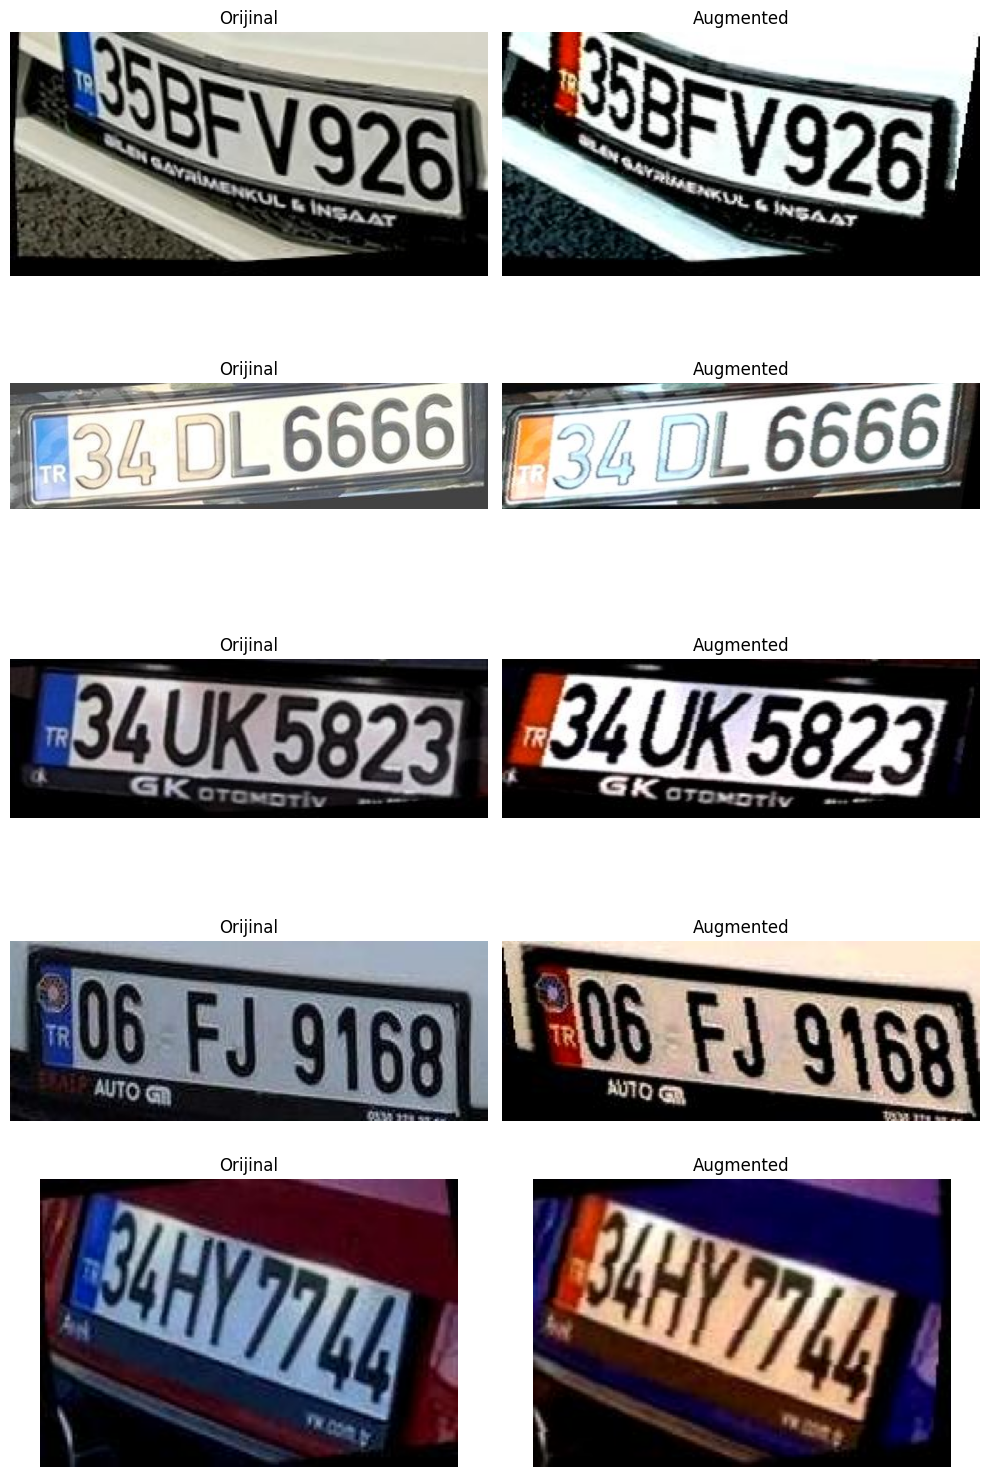

In [ ]:
import matplotlib.pyplot as plt

# Rastgele 5 orijinal görüntü seçilir
random_original_images = random.sample(image_files, min(5, len(image_files)))

# Seçilen görüntülere karşılık gelen augment edilmiş halleri alınır
random_augmented_images = [os.path.join(hard_augmented_path, "images", "hard_" + os.path.basename(img)) for img in random_original_images]

# Görseller yan yana gösterilir (sol: orijinal, sağ: augment)
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for i, (orig_path, aug_path) in enumerate(zip(random_original_images, random_augmented_images)):
    orig_img = cv2.imread(orig_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    aug_img = cv2.imread(aug_path)
    aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB) if aug_img is not None else None

    # Orijinal görüntü
    axes[i, 0].imshow(orig_img)
    axes[i, 0].axis("off")
    axes[i, 0].set_title("Orijinal")

    # Augmented görüntü
    if aug_img is not None:
        axes[i, 1].imshow(aug_img)
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Augmented")
    else:
        axes[i, 1].set_title("Augmented (Bulunamadı)")

plt.tight_layout()
plt.show()


In [ ]:
# Veri yolları tanımlanır
dataset_path = "/content/datasets/33-36-plaka.v1i.yolov8-1/train"
hard_character_only_path = "/content/datasets/hard_character_only"
hard_augmented_path = "/content/datasets/hard_augmented"
general_augmented_path = "/content/datasets/general_augmented"
train_final_path = "/content/datasets/train_final"

# Önceki varsa silinir, yeni birleşik klasör oluşturulur
if os.path.exists(train_final_path):
    shutil.rmtree(train_final_path)
os.makedirs(os.path.join(train_final_path, "images"), exist_ok=True)
os.makedirs(os.path.join(train_final_path, "labels"), exist_ok=True)

# General ve hard augment edilmiş dosyalar birleştirilir
for folder in [general_augmented_path, hard_augmented_path]:
    image_files = glob.glob(os.path.join(folder, "images", "*.jpg"))
    label_files = glob.glob(os.path.join(folder, "labels", "*.txt"))

    for img_file in image_files:
        shutil.copy(img_file, os.path.join(train_final_path, "images", os.path.basename(img_file)))

    for label_file in label_files:
        shutil.copy(label_file, os.path.join(train_final_path, "labels", os.path.basename(label_file)))

# Sonuç: toplam görsel ve etiket sayısı yazdırılır
final_images = len(glob.glob(os.path.join(train_final_path, "images", "*.jpg")))
final_labels = len(glob.glob(os.path.join(train_final_path, "labels", "*.txt")))

print(f"✅ Tüm augment edilmiş veriler birleştirildi! \nToplam Görüntü: {final_images} \nToplam Label: {final_labels}")


✅ Tüm augment edilmiş veriler birleştirildi! 
Toplam Görüntü: 3781 
Toplam Label: 3781


In [ ]:
# Veri yolu değişkenleri tanımlanır
dataset_path = "/content/datasets/33-36-plaka.v1i.yolov8-1/train"
hard_augmented_path = "/content/datasets/hard_augmented"
general_augmented_path = "/content/datasets/general_augmented"
train_final_path = "/content/datasets/train_final"

# Her klasördeki görsel ve etiket sayıları hesaplanır
dataset_images = len(glob.glob(os.path.join(dataset_path, "images", "*.jpg")))
dataset_labels = len(glob.glob(os.path.join(dataset_path, "labels", "*.txt")))

general_augmented_images = len(glob.glob(os.path.join(general_augmented_path, "images", "*.jpg")))
general_augmented_labels = len(glob.glob(os.path.join(general_augmented_path, "labels", "*.txt")))

hard_augmented_images = len(glob.glob(os.path.join(hard_augmented_path, "images", "*.jpg")))
hard_augmented_labels = len(glob.glob(os.path.join(hard_augmented_path, "labels", "*.txt")))

# Teorik olarak birleşince oluşması beklenen toplam sayılar
expected_total_images = dataset_images + general_augmented_images + hard_augmented_images
expected_total_labels = dataset_labels + general_augmented_labels + hard_augmented_labels

# train_final klasöründeki gerçek sayılar
final_images = len(glob.glob(os.path.join(train_final_path, "images", "*.jpg")))
final_labels = len(glob.glob(os.path.join(train_final_path, "labels", "*.txt")))

# Sonuçlar tabloya dönüştürülür
result = {
    "Orijinal Veri Görüntü Sayısı": dataset_images,
    "Orijinal Veri Label Sayısı": dataset_labels,
    "Genel Augmented Görüntü Sayısı": general_augmented_images,
    "Genel Augmented Label Sayısı": general_augmented_labels,
    "Özel Augmented Görüntü Sayısı": hard_augmented_images,
    "Özel Augmented Label Sayısı": hard_augmented_labels,
    "Beklenen Toplam Görüntü": expected_total_images,
    "Beklenen Toplam Label": expected_total_labels,
    "Gerçekleşen Toplam Görüntü": final_images,
    "Gerçekleşen Toplam Label": final_labels,
}

df = pd.DataFrame(list(result.items()), columns=["Özellik", "Sayı"])
df


,Özellik,Sayı
0,Orijinal Veri Görüntü Sayısı,1906
1,Orijinal Veri Label Sayısı,1906
2,Genel Augmented Görüntü Sayısı,1906
3,Genel Augmented Label Sayısı,1906
4,Özel Augmented Görüntü Sayısı,1875
5,Özel Augmented Label Sayısı,1875
6,Beklenen Toplam Görüntü-baştaki ile birleştirs...,5687
7,Beklenen Toplam Label,5687
8,Gerçekleşen Toplam Görüntü,3781
9,Gerçekleşen Toplam Label,3781


In [ ]:
# data.yaml dosyasının yolu
data_yaml_path = "/content/datasets/33-36-plaka.v1i.yolov8-1/data.yaml"

# YAML içeriği (33 sınıf ve sınıf isimleri + veri yolları)
data_yaml_content = """
nc: 33
names:
  - '0'
  - '1'
  - '2'
  - '3'
  - '4'
  - '5'
  - '6'
  - '7'
  - '8'
  - '9'
  - A
  - B
  - C
  - D
  - E
  - F
  - G
  - H
  - I
  - J
  - K
  - L
  - M
  - N
  - O
  - P
  - R
  - S
  - T
  - U
  - V
  - Y
  - Z
train: /content/datasets/train_final/images
val: /content/datasets/33-36-plaka.v1i.yolov8-1/valid/images
test: /content/datasets/33-36-plaka.v1i.yolov8-1/test/images
"""

# YAML dosyası diske yazılır
with open(data_yaml_path, "w") as f:
    f.write(data_yaml_content)

print("✅ data.yaml dosyası güncellendi ve ana dataset klasörüne kaydedildi!")


✅ data.yaml dosyası güncellendi ve ana dataset klasörüne kaydedildi!


In [ ]:
from ultralytics import YOLO
!pip install --upgrade ultralytics  # YOLOv8 güncellenir

# YOLOv8m modeli yüklenir (orta seviye model)
model = YOLO("yolov8m.pt")

# Model eğitimi başlatılır
model.train(
    data="/content/datasets/33-36-plaka.v1i.yolov8-1/data.yaml",  # YAML dosyası
    epochs=100,        # Maksimum epoch sayısı
    patience=20,       # 20 epoch boyunca iyileşme olmazsa durur
    imgsz=640,         # Giriş görüntü boyutu
    batch=32,          # Mini-batch boyutu (GPU gücüne göre düşürülebilir)
    workers=4,         # Colab için uygun iş parçacığı sayısı
    device="cuda",     # GPU kullanımı
    name="yolov8m-plate-reading"  # Eğitim klasör adı
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 49.7M/49.7M [00:00<00:00, 162MB/s]


Ultralytics 8.3.92 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/datasets/33-36-plaka.v1i.yolov8-1/data.yaml, epochs=100, time=None, patience=20, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=4, project=None, name=yolov8m-plate-reading, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sh

100%|██████████| 755k/755k [00:00<00:00, 20.5MB/s]


Overriding model.yaml nc=80 with nc=33

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 83.3MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/train_final/labels... 3781 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3781/3781 [00:01<00:00, 2336.84it/s]


train: New cache created: /content/datasets/train_final/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/33-36-plaka.v1i.yolov8-1/valid/labels... 545 images, 0 backgrounds, 0 corrupt: 100%|██████████| 545/545 [00:00<00:00, 722.34it/s]

val: New cache created: /content/datasets/33-36-plaka.v1i.yolov8-1/valid/labels.cache


Plotting labels to runs/detect/yolov8m-plate-reading/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00027, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8m-plate-reading
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      12.8G      1.671      2.494       1.55        106        640: 100%|██████████| 119/119 [01:59<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]

                   all        545       4155      0.912      0.881       0.93      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      12.2G      1.222      0.973      1.207         71        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.73it/s]

                   all        545       4155      0.924      0.942      0.963      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      12.2G      1.128     0.7622      1.138        102        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.79it/s]

                   all        545       4155       0.94      0.946      0.967      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      12.3G      1.103       0.71      1.127         70        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]

                   all        545       4155      0.943       0.96       0.97      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      12.4G      1.055     0.6469        1.1         83        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all        545       4155      0.965      0.967       0.98      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      12.4G       1.04     0.6302      1.098         63        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.81it/s]

                   all        545       4155       0.96      0.971      0.976      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      12.5G      1.002       0.59      1.077         90        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.81it/s]

                   all        545       4155      0.957      0.969      0.983      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      12.6G     0.9771     0.5721      1.062         69        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]

                   all        545       4155      0.963      0.971      0.985      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      12.6G     0.9608     0.5558      1.054         92        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]

                   all        545       4155      0.966      0.973      0.985      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      12.8G     0.9354     0.5278      1.039         70        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]

                   all        545       4155      0.963       0.97      0.986      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100        13G     0.9251     0.5232       1.04         66        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all        545       4155      0.962      0.976      0.986      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      13.1G     0.9162     0.5212      1.033         70        640: 100%|██████████| 119/119 [02:04<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]

                   all        545       4155      0.977       0.97      0.985      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      13.2G     0.9041     0.5083      1.028         94        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all        545       4155      0.966      0.969      0.984      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      13.4G     0.8844     0.4928      1.021         36        640: 100%|██████████| 119/119 [02:01<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]

                   all        545       4155      0.972      0.971      0.986      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      12.7G      0.873     0.4896      1.015         94        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.75it/s]

                   all        545       4155      0.966      0.975      0.985      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100        12G      0.865     0.4836      1.013        102        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]

                   all        545       4155      0.966      0.978      0.986      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100        12G     0.8442     0.4675          1         63        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all        545       4155      0.967      0.971      0.984      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      12.1G     0.8398     0.4647      1.003         93        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]

                   all        545       4155      0.974      0.976      0.986      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      12.2G     0.8284     0.4527     0.9944         64        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.87it/s]

                   all        545       4155      0.969      0.971      0.987      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      12.2G     0.8211     0.4495     0.9923         66        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.81it/s]

                   all        545       4155      0.973      0.973      0.987      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      12.3G     0.8122     0.4443     0.9892         78        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.79it/s]

                   all        545       4155      0.975      0.976      0.987      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      12.3G     0.8048     0.4487     0.9896         73        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]

                   all        545       4155      0.971      0.979      0.988        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      12.4G     0.7849     0.4266     0.9778         83        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]

                   all        545       4155      0.973      0.979      0.988      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      12.6G     0.7844     0.4328     0.9823         59        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.87it/s]

                   all        545       4155      0.975      0.976      0.991      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      12.7G     0.7699     0.4206     0.9714         87        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all        545       4155      0.968      0.981       0.99      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      12.9G     0.7714     0.4248     0.9752        101        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]

                   all        545       4155      0.973       0.98      0.989      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100        13G     0.7561     0.4139     0.9682        106        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.78it/s]

                   all        545       4155      0.974      0.981       0.99      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      13.2G     0.7561     0.4172     0.9686         57        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]

                   all        545       4155      0.978      0.979       0.99      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      13.3G     0.7422     0.4071     0.9629         60        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]

                   all        545       4155      0.973      0.979      0.986      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      12.6G     0.7326     0.4046     0.9634         59        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]

                   all        545       4155      0.973      0.981      0.989      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      12.2G     0.7302     0.3982      0.958         61        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.80it/s]

                   all        545       4155      0.979      0.977      0.989      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      12.2G     0.7222     0.3961     0.9573         63        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.59it/s]

                   all        545       4155      0.978      0.978       0.99      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      12.2G     0.7193      0.394     0.9602         80        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]

                   all        545       4155      0.982      0.981      0.989      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      12.3G     0.6946     0.3841     0.9462        100        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all        545       4155      0.973      0.981      0.989      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      12.4G     0.6932     0.3827     0.9455        100        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all        545       4155      0.976      0.979      0.987      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      12.4G     0.6894     0.3792     0.9432         54        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.75it/s]

                   all        545       4155      0.974      0.979      0.989      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      12.5G     0.6817     0.3726      0.942         92        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]

                   all        545       4155      0.975      0.981      0.991      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      12.5G     0.6769     0.3722      0.942         98        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]

                   all        545       4155      0.979      0.982      0.991      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      12.6G     0.6661     0.3685      0.936         78        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]

                   all        545       4155       0.98      0.979      0.991      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      12.7G     0.6639     0.3635     0.9351         77        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.79it/s]

                   all        545       4155      0.976      0.981      0.988      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      12.9G     0.6497     0.3552     0.9285         60        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]

                   all        545       4155      0.976       0.98       0.99      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100        13G     0.6455     0.3558      0.928         70        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all        545       4155      0.979      0.979      0.988      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      13.2G     0.6395     0.3555     0.9275         82        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]

                   all        545       4155      0.981       0.98       0.99      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      13.3G     0.6388     0.3544     0.9248         92        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]

                   all        545       4155      0.975      0.982       0.99      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      12.8G     0.6297     0.3512      0.922         68        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]

                   all        545       4155      0.974      0.981      0.989      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100        12G     0.6239     0.3461     0.9214         81        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]

                   all        545       4155      0.978      0.982      0.989      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100        12G     0.6176     0.3433      0.917         82        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]

                   all        545       4155      0.978      0.982       0.99      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      12.1G     0.6169     0.3433     0.9193         85        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]

                   all        545       4155      0.975      0.984      0.989      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      12.1G      0.604     0.3355     0.9115         91        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]

                   all        545       4155      0.985      0.977       0.99      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      12.2G     0.5989     0.3347     0.9092         77        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]

                   all        545       4155      0.978       0.98       0.99      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      12.3G     0.5979     0.3349     0.9121         75        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.58it/s]

                   all        545       4155      0.977       0.98      0.988      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      12.3G     0.5883     0.3313     0.9089         64        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]

                   all        545       4155      0.976      0.984      0.989      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      12.4G     0.5878     0.3309     0.9065         44        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all        545       4155      0.982      0.979       0.99      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      12.6G     0.5745     0.3241     0.9018         58        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.87it/s]

                   all        545       4155      0.976      0.983      0.991      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      12.7G     0.5728     0.3228     0.9018         55        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]

                   all        545       4155      0.979      0.981      0.992      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      12.9G      0.571     0.3221     0.9004         81        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]

                   all        545       4155      0.975      0.984      0.989      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100        13G     0.5647     0.3158     0.8989         61        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]

                   all        545       4155      0.979      0.982      0.991      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      13.2G     0.5601     0.3152     0.8967         62        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all        545       4155      0.978      0.981       0.99      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      13.4G     0.5563      0.314     0.8949         62        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]

                   all        545       4155       0.98      0.982      0.991      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      12.6G     0.5513     0.3142     0.8943         83        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.79it/s]

                   all        545       4155      0.976      0.983      0.991      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      12.2G     0.5459     0.3143     0.8932         74        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]

                   all        545       4155      0.979      0.981      0.989       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      12.2G     0.5451     0.3093     0.8923         85        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]

                   all        545       4155      0.975      0.984      0.989      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      12.2G      0.538      0.308     0.8914         82        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]

                   all        545       4155      0.981      0.981      0.991       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      12.3G     0.5301     0.3059     0.8879         55        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.80it/s]

                   all        545       4155      0.986       0.98       0.99       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      12.4G     0.5279      0.304     0.8898         92        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.80it/s]

                   all        545       4155      0.981      0.981      0.989       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      12.4G     0.5157     0.2988     0.8841        103        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]

                   all        545       4155       0.98      0.981       0.99       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      12.5G     0.5194     0.2996     0.8859         81        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]

                   all        545       4155      0.982       0.98      0.989      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      12.6G     0.5167     0.3007     0.8851         56        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all        545       4155      0.977      0.983      0.991      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      12.6G       0.51     0.2957     0.8823         77        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.79it/s]

                   all        545       4155      0.983      0.979      0.989      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      12.7G     0.5045     0.2903     0.8798         69        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all        545       4155      0.983      0.981       0.99      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      12.8G     0.5005     0.2898     0.8782         58        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]

                   all        545       4155      0.984      0.978      0.989      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100        13G     0.4956     0.2891     0.8779         63        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]

                   all        545       4155      0.981      0.982      0.991      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      13.2G     0.4873      0.283     0.8713         80        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]

                   all        545       4155      0.983      0.979      0.991      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      13.3G     0.4907     0.2835      0.875         85        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]

                   all        545       4155      0.985       0.98      0.992      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      12.8G     0.4805     0.2817     0.8718         83        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.72it/s]

                   all        545       4155      0.983      0.981      0.991      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100        12G     0.4791     0.2796     0.8712         69        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]

                   all        545       4155      0.982       0.98       0.99      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100        12G      0.474     0.2786     0.8687         87        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]

                   all        545       4155      0.981       0.98       0.99      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      12.1G     0.4729     0.2771     0.8678        100        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all        545       4155      0.986       0.98      0.989      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      12.1G     0.4671     0.2778     0.8659         71        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all        545       4155      0.982      0.981      0.991      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      12.2G     0.4681     0.2781     0.8679         63        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]

                   all        545       4155      0.985       0.98      0.989      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      12.3G     0.4619     0.2727     0.8652        102        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all        545       4155      0.983      0.983       0.99      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      12.3G     0.4559     0.2696     0.8637         99        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]

                   all        545       4155      0.983      0.981       0.99      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      12.4G     0.4512     0.2673     0.8627         84        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]

                   all        545       4155      0.983      0.981      0.991      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      12.5G     0.4473     0.2658     0.8604        108        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]

                   all        545       4155      0.982      0.984      0.991      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      12.7G     0.4452     0.2668     0.8594         94        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all        545       4155      0.985      0.981      0.991      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      12.9G     0.4387     0.2615     0.8578         70        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]

                   all        545       4155      0.984      0.982       0.99      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100        13G     0.4372     0.2619     0.8597         66        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]

                   all        545       4155      0.984      0.981       0.99      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      13.1G     0.4328     0.2607     0.8557         75        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all        545       4155      0.983       0.98      0.991      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      13.3G     0.4308      0.259     0.8558         52        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]

                   all        545       4155      0.981      0.981       0.99      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      12.7G     0.4284     0.2598     0.8556         78        640: 100%|██████████| 119/119 [02:05<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.78it/s]

                   all        545       4155      0.986      0.979      0.991      0.837


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      12.2G     0.3867     0.1855     0.8387         35        640: 100%|██████████| 119/119 [02:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all        545       4155      0.985       0.98       0.99      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      12.2G     0.3619      0.175     0.8285         39        640: 100%|██████████| 119/119 [02:03<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]

                   all        545       4155      0.984       0.98       0.99      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      12.2G     0.3551     0.1728     0.8269         40        640: 100%|██████████| 119/119 [02:03<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.73it/s]

                   all        545       4155      0.986       0.98       0.99      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      12.3G     0.3527     0.1722     0.8258         29        640: 100%|██████████| 119/119 [02:03<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all        545       4155      0.986      0.981      0.989      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      12.4G     0.3437     0.1688     0.8246         39        640: 100%|██████████| 119/119 [02:03<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.82it/s]

                   all        545       4155      0.986       0.98       0.99      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      12.4G     0.3388     0.1666     0.8222         37        640: 100%|██████████| 119/119 [02:03<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.75it/s]

                   all        545       4155      0.986       0.98       0.99      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      12.5G     0.3367     0.1666     0.8195         37        640: 100%|██████████| 119/119 [02:03<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.63it/s]

                   all        545       4155      0.986      0.981       0.99      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      12.6G     0.3322     0.1647     0.8183         34        640: 100%|██████████| 119/119 [02:03<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

                   all        545       4155      0.985      0.981       0.99      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      12.6G     0.3309      0.164     0.8193         39        640: 100%|██████████| 119/119 [02:03<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]

                   all        545       4155      0.985      0.981       0.99      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      12.7G     0.3276     0.1626     0.8204         32        640: 100%|██████████| 119/119 [02:03<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all        545       4155      0.985      0.981       0.99      0.836



100 epochs completed in 3.715 hours.
Optimizer stripped from runs/detect/yolov8m-plate-reading/weights/last.pt, 52.1MB
Optimizer stripped from runs/detect/yolov8m-plate-reading/weights/best.pt, 52.1MB

Validating runs/detect/yolov8m-plate-reading/weights/best.pt...
Ultralytics 8.3.92 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,858,867 parameters, 0 gradients, 78.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


                   all        545       4155      0.986      0.979      0.991      0.837
                     0        232        294      0.993      0.987      0.991      0.853
                     1        199        241      0.965      0.992      0.982      0.795
                     2        205        222      0.995      0.989      0.995      0.844
                     3        325        428      0.991      0.996      0.993      0.854
                     4        300        379      0.987      0.994      0.987      0.832
                     5        238        292          1      0.993      0.995      0.855
                     6        234        269      0.999      0.993      0.995      0.862
                     7        185        206       0.99      0.966      0.995      0.825
                     8        199        229      0.983      0.984      0.992      0.843
                     9        155        179          1      0.974      0.995      0.835
                     

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c274d107a50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039

In [ ]:
from ultralytics import YOLO

# Eğitim sonrası en iyi modeli yükle
model = YOLO("/content/runs/detect/yolov8m-plate-reading/weights/best.pt")

# Model, test veri seti üzerindeki görüntülerde tahmin çalıştırır
results = model.predict(
    source="/content/datasets/33-36-plaka.v1i.yolov8-1/test/images",  # Test görüntü klasörü
    save=True  # Tahmin sonuçlarını görsel olarak da kaydet
)



image 1/272 /content/datasets/33-36-plaka.v1i.yolov8-1/test/images/1003_jpg.rf.e7e6c14225e405b381c6583110fbde36.jpg: 576x640 2 7s, 1 8, 125.6ms
image 2/272 /content/datasets/33-36-plaka.v1i.yolov8-1/test/images/1008_jpg.rf.0d1c83d44ad9667d276d4cee0b4d4522.jpg: 192x640 1 0, 1 4, 1 5, 1 6, 1 7, 1 V, 1 Z, 44.1ms
image 3/272 /content/datasets/33-36-plaka.v1i.yolov8-1/test/images/100_jpg.rf.0ac206db7ab98eed8550f0fad4b49c43.jpg: 192x640 1 2, 4 5s, 1 D, 1 T, 16.6ms
image 4/272 /content/datasets/33-36-plaka.v1i.yolov8-1/test/images/100_jpg.rf.149cd4fc1bd286de3e46c8a7876de756.jpg: 192x640 1 2, 4 5s, 1 D, 1 T, 16.7ms
image 5/272 /content/datasets/33-36-plaka.v1i.yolov8-1/test/images/1011_jpg.rf.c14ea8d084ec741137efabe266ad936a.jpg: 192x640 1 1, 1 3, 2 4s, 1 6, 1 E, 1 L, 1 P, 16.5ms
image 6/272 /content/datasets/33-36-plaka.v1i.yolov8-1/test/images/1022_jpg.rf.9f58eac75aee1914342e03c91ba839fe.jpg: 352x640 1 3, 1 4, 1 6, 1 8, 1 9, 1 B, 1 H, 1 V, 44.0ms
image 7/272 /content/datasets/33-36-plaka.v1

In [3]:
metrics = model.val()
print(metrics)


Ultralytics 8.3.92 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/datasets/33-36-plaka.v1i.yolov8-1/valid/labels.cache... 545 images, 0 backgrounds, 0 corrupt: 100%|██████████| 545/545 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:09<00:00,  3.59it/s]


                   all        545       4155      0.986      0.979      0.991      0.837
                     0        232        294      0.993      0.988      0.991      0.853
                     1        199        241      0.966      0.992      0.982      0.797
                     2        205        222      0.995       0.99      0.995      0.842
                     3        325        428      0.991      0.997      0.993      0.854
                     4        300        379      0.987      0.997      0.986      0.833
                     5        238        292      0.999      0.993      0.995      0.854
                     6        234        269      0.999      0.993      0.995      0.863
                     7        185        206       0.99      0.966      0.995      0.825
                     8        199        229      0.983      0.981      0.993      0.843
                     9        155        179      0.998      0.972      0.995      0.831
                     

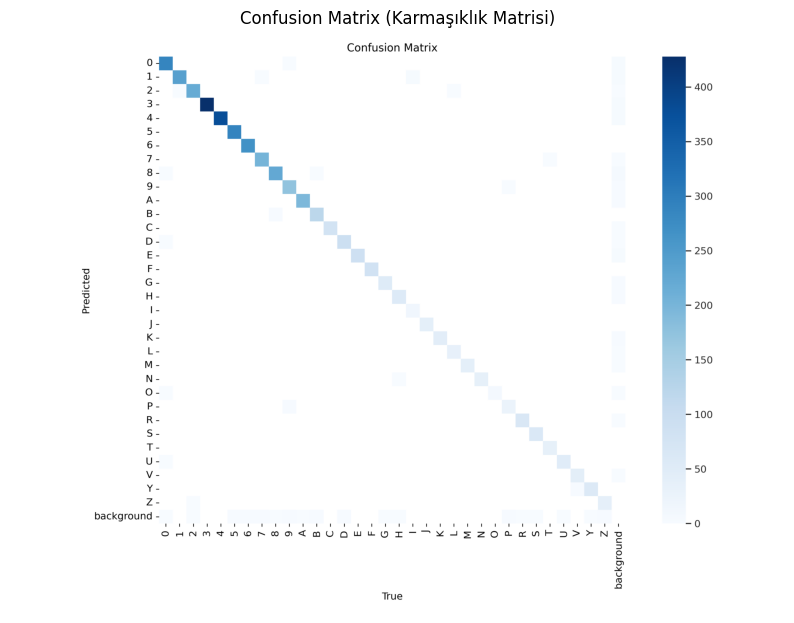

In [ ]:
import cv2  # OpenCV kütüphanesi; görüntü işleme işlemleri için kullanılır
import matplotlib.pyplot as plt  # Görselleştirme işlemleri için kullanılır

# Kayıtlı Confusion Matrix (Karmaşıklık Matrisi) görselinin yolunu belirt
confusion_matrix_path = "/content/runs/detect/val/confusion_matrix.png"  # Görselin tam yolu belirtiliyor

# Görseli yükle
conf_matrix = cv2.imread(confusion_matrix_path)  # OpenCV ile görsel dosyası okunuyor (BGR formatında)
conf_matrix = cv2.cvtColor(conf_matrix, cv2.COLOR_BGR2RGB)  # OpenCV BGR formatında okuduğundan RGB formatına çevriliyor

# Görseli matplotlib ile göster
plt.figure(figsize=(10, 8))  # Grafik boyutu belirleniyor
plt.imshow(conf_matrix)  # Görsel gösteriliyor
plt.axis("off")  # Eksen etiketleri gizleniyor
plt.title("Confusion Matrix (Karmaşıklık Matrisi)")  # Başlık ekleniyor
plt.show()  # Görsel ekrana bastırılıyor


Ultralytics 8.3.92 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/datasets/33-36-plaka.v1i.yolov8-1/valid/labels.cache... 545 images, 0 backgrounds, 0 corrupt: 100%|██████████| 545/545 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:09<00:00,  3.76it/s]


                   all        545       4155      0.986      0.979      0.991      0.837
                     0        232        294      0.993      0.988      0.991      0.853
                     1        199        241      0.966      0.992      0.982      0.797
                     2        205        222      0.995       0.99      0.995      0.842
                     3        325        428      0.991      0.997      0.993      0.854
                     4        300        379      0.987      0.997      0.986      0.833
                     5        238        292      0.999      0.993      0.995      0.854
                     6        234        269      0.999      0.993      0.995      0.863
                     7        185        206       0.99      0.966      0.995      0.825
                     8        199        229      0.983      0.981      0.993      0.843
                     9        155        179      0.998      0.972      0.995      0.831
                     

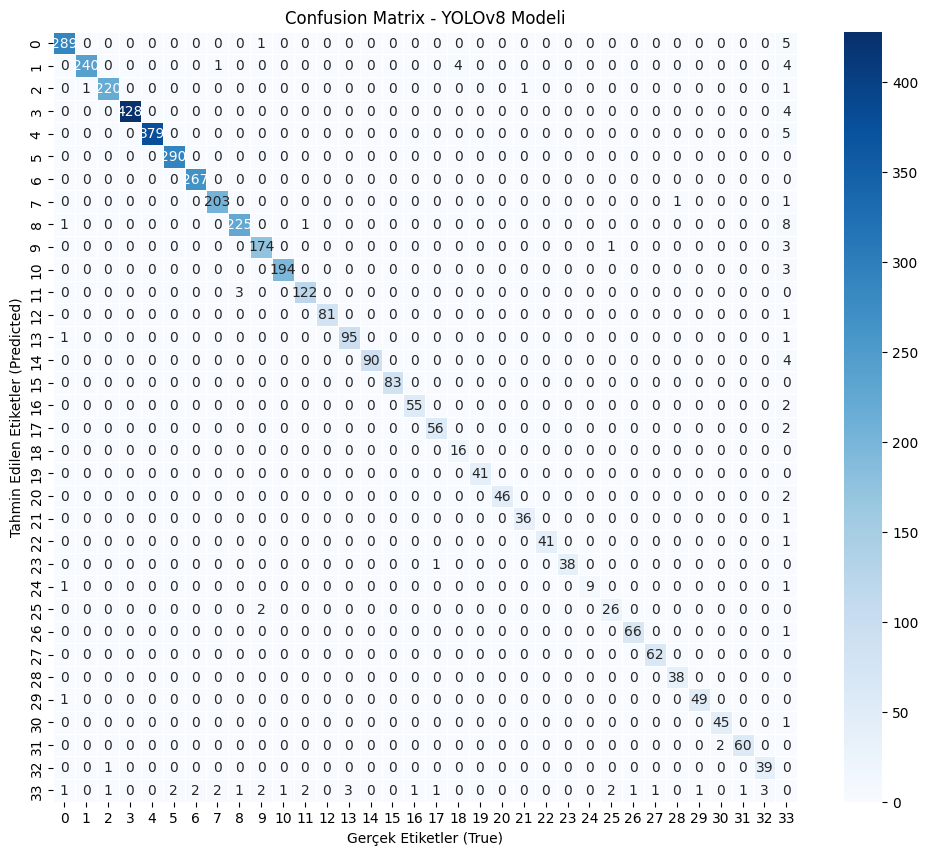

In [ ]:
# Confusion Matrix’i yeniden yükle
conf_matrix = model.val().confusion_matrix.matrix  # Modelin doğrulama sonuçlarından karmaşıklık matrisini al

# Matrisin şekli düzgün mü kontrol et
print(f"Confusion Matrix Boyutu: {conf_matrix.shape}")  # Matrisin boyutunu yazdır (örneğin: 33x33 sınıf varsa 33x33 olur)

# Confusion Matrix’i çizdir
plt.figure(figsize=(12, 10))  # Grafik boyutunu belirle
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", linewidths=0.5)  # Matris değerlerini sayılarla birlikte göster
plt.xlabel("Gerçek Etiketler (True)")  # X ekseni etiketi
plt.ylabel("Tahmin Edilen Etiketler (Predicted)")  # Y ekseni etiketi
plt.title("Confusion Matrix - YOLOv8 Modeli")  # Grafik başlığı
plt.show()  # Görselleştirmeyi göster


In [ ]:
import numpy as np

# Doğru tahmin edilen toplam örnekleri al
true_predictions = np.trace(conf_matrix)  # Confusion Matrix'in köşegenindeki değerler: doğru tahmin edilen sınıflar

# Modelin toplam tahmin sayısını al
total_predictions = np.sum(conf_matrix)  # Matristaki tüm hücrelerin toplamı: tüm tahmin edilen örnek sayısı

# Genel doğruluk oranı
accuracy = true_predictions / total_predictions  # Doğru tahminler / Toplam tahmin

# Sonucu yazdır
print(f"✅ Modelin Genel Doğruluk Oranı: {accuracy:.4f} (%{accuracy * 100:.2f})")  # Oran*


✅ Modelin Genel Doğruluk Oranı: 0.9755 (%97.55)


In [ ]:
import numpy as np

# Örnek karmaşıklık matrisi (Confusion Matrix)
# Her satır: gerçek etiket
# Her sütun: modelin tahmin ettiği etiket
# Her hücre: o sınıf için yapılan doğru veya yanlış tahmin sayısı

confusion_matrix = np.array([
    [288, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 240, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 220, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 379, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
    [0, 0, 0, 0, 990, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 267, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 203, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 174, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6]
])

# Matristeki tüm tahminlerin toplamı (hem doğru hem yanlış tahminleri içerir)
total_predictions = np.sum(confusion_matrix)

# Toplam tahmin sayısını yazdır
total_predictions


np.int64(3127)

In [ ]:
import os
import glob

# Eğitim veri kümesindeki tüm .jpg dosyalarını bul
train_images = glob.glob("/content/datasets/train_final/images/*.jpg")  # Eğitim veri yolunu doğrula

# Bulunan görüntü sayısını yazdır
print(f"Toplam Eğitim Görüntüsü: {len(train_images)}")


Toplam Eğitim Görüntüsü: 3781


In [ ]:
val_images = glob.glob("/content/datasets/33-36-plaka.v1i.yolov8-1/valid/images/*.jpg")  # Validation veri yolu

# Doğrulama (validation) setindeki toplam .jpg uzantılı görüntü dosyalarını sayar
print(f"Toplam Doğrulama Görüntüsü: {len(val_images)}")


Toplam Doğrulama Görüntüsü: 545


tarin sonucu batch size ve iterasyona göre 3808 veri kullanıldığı hesaplanıyıor  Ultralytics YOLOv8, eğitim sırasında verileri varsayılan olarak karıştırır (shuffle=True). Her epoch’ta farklı Instances sayıları görüyorsan, bu shuffle’ın açık olduğunu gösterir.bundan dolayı farklılık olabiliyormuş.